In [18]:
import scipy as sp
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import time

def calculate_energy( pattern, template, offset_x, offset_y ):
    """
    Normalisation for 2D slice of NxM size array of same length of pattern passed.
    norm= sqrt( sum(f[i]^2) * sum(g[m]^2) )
 
    Inputs:
    ----------------
        p   must be non empty and sum-square of its elements precalculated and passed

        t   similar dimensionality to pattern

        offset_x  position in the template/search array along rows

        offset_y  position in the template/search array along columns
        
    Output:
    ----------------
        norm  Scalar float of variance for a given an array slice of the template/search and pattern
     """    
    g_slice = template[ offset_x : offset_x +pattern.shape[0],  offset_y : offset_y + pattern.shape[1]] 
    norm = np.sqrt( ( pattern**2 ).sum() * ( g_slice**2).sum() ) 
    #Where 0 values not caught by corr function, print to see where they occur
    if norm == 0 :
        print ("p=", pattern, "template=", g_slice, "offset_x = ", offset_x, "offset_y = ", offset_y, "\n")

    return norm



def calculate_score( pattern, template, offset_x, offset_y):
    """
    Correlation for 2D slice of NxM size template/search array with pattern at given offset. Sum(f[i]*g[i+m])
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty and sum-square of its elements precalculated and passed

        template   Template with similar dimensionality to pattern

        offset  Offset position in the template/search array
        
    Output:
    ----------------
        score  Scalar float of correlation score between pattern and template slice
     """        

    score = (pattern * template[ offset_x : offset_x +pattern.shape[0],  offset_y : offset_y + pattern.shape[1]] ).sum()

    return score



def zero_padding(array, padlen_x, padlen_y):
    """
    Zero pad 2D array by placing it in centre of zeroed matrix of padded size.
 
    Inputs:
    ----------------
        array   The array to pad
 
        padlen_x    Padwidth of the rows. Floats will be rounded up.
        
        padlen_y    Padwidth of the columns. Floats will be rounded up.
 
    Output:
    ----------------
        padded  Padded template array.  
     """        
    m,n = array.shape
    padded = np.zeros((m +2*padlen_x , n+2*padlen_y ),dtype=array.dtype)
    padded[padlen_x:-padlen_x:, padlen_y:-padlen_y] = array
    return padded


#function that finds the largest element and its index in an array
def find_best_match( score ):
    """
    Find max value in 2D array and its index
 
    Inputs:
    ----------------
        score   2D target array
        
    Output:
    ----------------
        index   Index of largest element 
        
        max_element Max Element in the array

     """        
    #try:
    max_element = np.amax( score )
    #except:
    #    print( "Line 45 Error", score )
    index = np.unravel_index(np.argmax( score, axis=None), score.shape) 

    return index, max_element 


def n_corr2d( pattern, template):
    """
    Normed cross correlation of two 2D arrays
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty 

        template   Template, search space with similar dimensionality to pattern
        
    Output:
    ----------------
        norm_scores  Normed cross correlation array
     """    

    #Pad and initalise arrays for calculation  
    #  
    template = zero_padding( template, pattern.shape[0], pattern.shape[1] )
    side_edge = template.shape[0] - pattern.shape[0] 
    bottom_edge = template.shape[1] - pattern.shape[1]
    
    scores = np.zeros( ( side_edge ,  bottom_edge ) )
    norm =  np.zeros( ( side_edge ,  bottom_edge ) )
    norm_scores =  np.zeros( ( side_edge ,  bottom_edge ) )
    #test = [0] * ( len( template ) - len( pattern ) )
    


    for i in range( scores.shape[0] ):
        #t_start = time.time()
        for j in range( scores.shape[1] ):
            scores[ i, j ] = calculate_score( pattern, template, i, j)
            #norm[ i ] = g( pattern, template, i)
            #print( scores )
            if  scores[i,j]!=0 : 
                norm[ i, j ] = calculate_energy( pattern, template, i, j)
                norm_scores[ i, j ] = scores[ i, j ]/norm[ i , j ] 
        #tn = time.time()
        #print( f'{ i } run time =  { tn - t_start}')
        
        #print( "s=", scores,"\n", "n=", norm, "\n")


    return norm_scores



def find_offset(pattern, template): 
    """
    2D array offset index and value from normed cross correlation 
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty 

        template   Template, search space with similar dimensionality to pattern
        
    Output:
    ----------------
        (best_score, best_match)  Index of offset found from cross correlation
     """     

    norm_corr = n_corr2d( pattern, template)

    #Plot array of cross correlation
    plt.figure()
    plt.plot(norm_corr)

    #best_score, best_match = find_best_match( scores )
    best_match , match_value = find_best_match( norm_corr )
    #print( best_match )

    #subtracting centred offset
    return (best_match[0] - pattern.shape[0]  + 1, best_match[1] -  pattern.shape[1]  + 1 ), match_value

    
def read_image(image_name):
    """
    Read image 
 
    Inputs:
    ----------------
        image_name   Image path 
 
    Output:
    ----------------
        img  Image as multi channel array
       """  
    img = mpimg.imread(image_name)
    #im_array = np.array(img)

    return img

In [19]:
def convert_gray(image):
    height = image.shape[0]
    width = image.shape[1]
    r = 0.299
    g = 0.587
    b = 0.114
    grey = np.zeros((image.shape[0],image.shape[1]))

    for i in range(height): 
        for j in range(width): 
            grey[i][j] = (r*image[i][j][0] + g*image[i][j][1] + b*image[i][j][2])/3  
    
    return grey
    #return image[:,:,0:3].mean(axis=2)

    

In [34]:
patternDir = "wallypuzzle_rocket_man.png"
templateDir = "wallypuzzle_png.png"

pattern = np.array(read_image( patternDir ) )
template = np.array(read_image( templateDir ) )

#gray 1
pattern_g1 = convert_gray( pattern )
template_g1 = convert_gray( template )

#mean 1
pattern_s1 = pattern_g1 - np.mean(pattern_g1)
template_s1 = template_g1 - np.mean(template_g1)


#gray 1
pattern_g2 = 0.2989 * pattern[:, :, 0] + 0.5870 * pattern[:, :, 0] + 0.1140 * pattern[:, :, 0]
template_g2 = 0.2989 * template[:, :, 0] + 0.5870 * template[:, :, 0] + 0.1140 * template[:, :, 0]

#mean 1
pattern_s2 = pattern_g2 - np.mean(pattern_g2)
template_s2 = template_g2 - np.mean(template_g2)

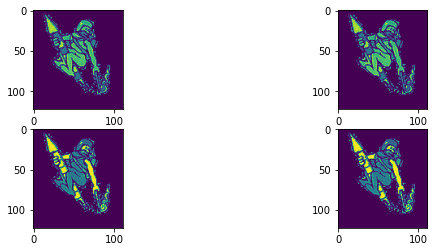

In [35]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(2,2,1)
plt.imshow(pattern_g1)
plt.subplot(2,2,2)
plt.imshow(pattern_s1)
plt.subplot(2,2,3)
plt.imshow(pattern_g2)
plt.subplot(2,2,4)
plt.imshow(pattern_s2)


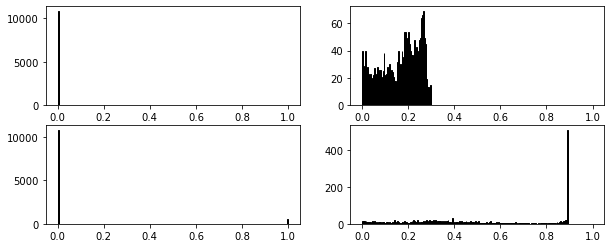

In [36]:
lum_img_1 = pattern_g1[:, :]
lum_img_2 = pattern_s1[:, :]
lum_img_3 = pattern_g2[:, :]
lum_img_4 = pattern_s2[:, :]
fig = plt.figure(figsize=(10, 4))
plt.subplot(2,2,1)  
plt.hist(lum_img_1.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.subplot(2,2,2)  
plt.hist(lum_img_2.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.subplot(2,2,3)
plt.hist(lum_img_3.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.subplot(2,2,4)
plt.hist(lum_img_4.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.show()

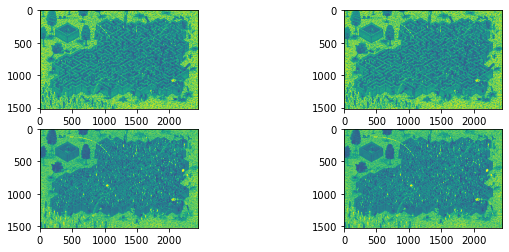

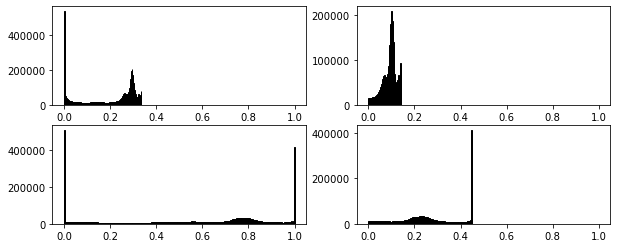

In [37]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(2,2,1)
plt.imshow(template_g1)
plt.subplot(2,2,2)
plt.imshow(template_s1)
plt.subplot(2,2,3)
plt.imshow(template_g2)
plt.subplot(2,2,4)
plt.imshow(template_s2)

lum_img_1 = template_g1[:, :]
lum_img_2 = template_s1[:, :]
lum_img_3 = template_g2[:, :]
lum_img_4 = template_s2[:, :]
fig = plt.figure(figsize=(10, 4))
plt.subplot(2,2,1)  
plt.hist(lum_img_1.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.subplot(2,2,2)  
plt.hist(lum_img_2.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.subplot(2,2,3)
plt.hist(lum_img_3.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.subplot(2,2,4)
plt.hist(lum_img_4.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.show()

Offset_x =  529 Offset_y =  983 Cross value =  0.47567135794863613 run time =  180.8713309764862


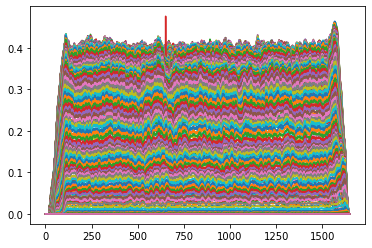

In [38]:
start = time.time()
# read average of image. Finish by converting to greyscale 
# Find position of max ccr value, where the pattern image is found in
# template
image_cross, image_cross_value = find_offset( pattern_g1, template_g1 )
end = time.time()
print( "Offset_x = ", image_cross[0], "Offset_y = ", image_cross[1], "Cross value = ", image_cross_value, "run time = ", end - start  )


Offset_x =  529 Offset_y =  983 Cross value =  0.27584330905386806 run time =  187.79836201667786


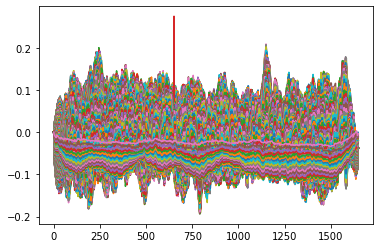

In [39]:
start = time.time()
# read average of image. Finish by converting to greyscale 
# Find position of max ccr value, where the pattern image is found in
# template
image_cross, image_cross_value = find_offset( pattern_s1, template_s1 )
end = time.time()
print( "Offset_x = ", image_cross[0], "Offset_y = ", image_cross[1], "Cross value = ", image_cross_value, "run time = ", end - start  )


Offset_x =  529 Offset_y =  983 Cross value =  0.530864554473813 run time =  165.00196957588196


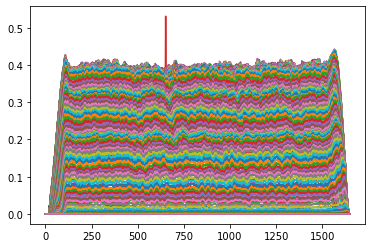

In [40]:
start = time.time()
# read average of image. Finish by converting to greyscale 
# Find position of max ccr value, where the pattern image is found in
# template
image_cross, image_cross_value = find_offset( pattern_g2, template_g2 )
end = time.time()
print( "Offset_x = ", image_cross[0], "Offset_y = ", image_cross[1], "Cross value = ", image_cross_value, "run time = ", end - start  )


Offset_x =  529 Offset_y =  983 Cross value =  0.3724158963277624 run time =  167.4924819469452


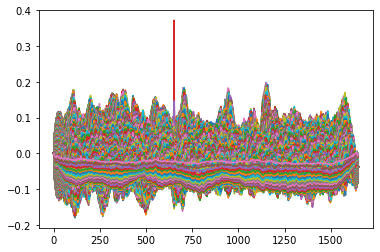

In [41]:
start = time.time()
# read average of image. Finish by converting to greyscale 
# Find position of max ccr value, where the pattern image is found in
# template
image_cross, image_cross_value = find_offset( pattern_s2, template_s2 )
end = time.time()
print( "Offset_x = ", image_cross[0], "Offset_y = ", image_cross[1], "Cross value = ", image_cross_value, "run time = ", end - start  )
